In [1]:
# I have a tendency to import everthing on the planet so I hope u have ram

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Concatenate, Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras_tuner as kt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.regularizers import l1, l2, L1L2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.losses import MeanSquaredError
import tifffile as tiff
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import imagecodecs
import cv2
import os
import PIL

from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import seaborn as sns


Lets load the excel with pandas!

In [2]:
df = pd.read_excel('Path1/Path1-Model Training/Path1 Challenge Training Data.xlsx')
directory = 'Path1/Path1-Model Training/Path1 Challenge Training Images/'

In [3]:
def load_images_from_folder(folder, target_size=(224, 224)):
    images = []
    files = sorted(os.listdir(folder))  # Sort the list of files
    for filename in files:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            resized_img = cv2.resize(img, target_size)  # Resize the image
            images.append(resized_img)
    return np.array(images)

In [4]:
directory = 'Path1/Path1-Model Training/Path1 Challenge Training Images/'

df = pd.read_excel('Path1/Path1-Model Training/Path1 Challenge Training Data.xlsx')
df = df[df['Grade Category'] != 'Standard']

grade_mapping = {'Select': 0, 'Low Choice': 1, 'Upper 2/3 Choice': 2, 'Prime': 3}
class_names = "Select", "Low Choice", "Upper 2/3 Choice", "Prime"

df['Label'] = df['Grade Category'].map(grade_mapping)

In [5]:
file_list = sorted(os.listdir(directory))
df_filtered = df[df['Filename'].isin(file_list)]

In [6]:
all_images = load_images_from_folder(directory, target_size=(224, 224))

all_labels = []
filtered_images = []

# extract label from each filename
for filename in file_list:
    if filename in df_filtered['Filename'].values:
        label = df_filtered[df_filtered['Filename'] == filename]['Label'].values[0]
        all_labels.append(label)

        #filter images because the first one file is not in the filtered df
        filtered_images.append(all_images[file_list.index(filename)])

# make them arrays
all_labels = np.array(all_labels)
filtered_images = np.array(filtered_images)

In [7]:
train_data, validation_data = train_test_split(df_filtered, test_size=0.2, random_state=42)

# split the images themselves in case we do some visualizations
train_images, validation_images, train_labels, validation_labels = train_test_split(
    filtered_images, 
    all_labels, 
    test_size=0.2, 
    random_state=42
)


In [8]:
print(df_filtered.tail())

            Filename  Carcass_ID  Score    Grade Category  Label
1397  00008196-1.tif        8196  440.0        Low Choice      1
1398  00008197-1.tif        8197  476.7        Low Choice      1
1399  00008198-1.tif        8198  533.3  Upper 2/3 Choice      2
1400  00008199-1.tif        8199  586.7  Upper 2/3 Choice      2
1401  00008200-1.tif        8200  676.7  Upper 2/3 Choice      2
[1 2 3 0]
[1 2 0 3]


In [12]:
validation_labels

array([1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 0, 1, 1, 1, 2, 1, 1, 1, 0, 2, 1,
       0, 2, 2, 1, 1, 3, 1, 2, 1, 0, 1, 2, 1, 2, 2, 1, 1, 2, 3, 1, 2, 1,
       2, 1, 1, 0, 1, 1, 0, 1, 2, 1, 0, 2, 2, 2, 1, 2, 3, 3, 2, 2, 1, 2,
       2, 2, 1, 0, 1, 1, 2, 1, 0, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 2, 0, 2, 1, 1, 2, 2, 1, 1, 2, 2, 0, 2, 2, 1, 2, 2, 1, 1, 2, 1,
       2, 2, 1, 1, 2, 1, 1, 0, 2, 1, 2, 1, 0, 0, 1, 2, 2, 1, 0, 1, 1, 1,
       2, 3, 1, 1, 1, 2, 2, 2, 2, 0, 3, 2, 2, 2, 1, 2, 2, 1, 0, 2, 1, 2,
       3, 3, 2, 2, 0, 0, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 1,
       1, 1, 2, 1, 2, 0, 2, 2, 0, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2,
       1, 3, 1, 2, 1, 1, 2, 1, 0, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       0, 2, 1, 1, 1, 1, 2, 1, 3, 1, 3, 2, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 3, 1, 2, 1, 3, 1, 2, 2, 0, 1, 0, 1, 2, 1, 0, 1, 2, 0, 2,
       1, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 1, 1, 3, 2, 2, 2], dtype=int64)

In [10]:
datagen = ImageDataGenerator(rescale=1./255)

In [13]:

# inputs our images into the augment and preps into tensors for model
train_generator_score = datagen.flow(
    #X_resampled_reshaped,
    #y_resampled_one_hot,
    all_images[train_data.index],
    train_data['Score'],
    batch_size=32,
    shuffle=True
)

# preps images for model
validation_generator_score = datagen.flow(
    all_images[validation_data.index],
    validation_data['Score'],
    batch_size=32,
    shuffle=False
)

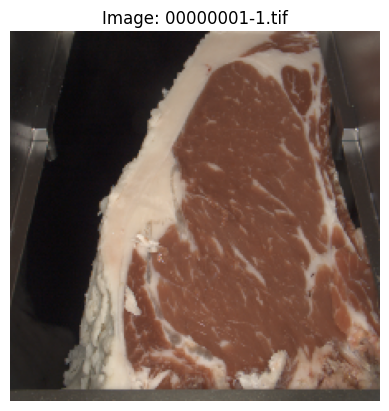

In [14]:
image_filename = df['Filename'].iloc[0]  # first image

image_path = os.path.join(directory, image_filename)

# plot
img = image.load_img(image_path, target_size=(224, 224))
plt.imshow(img)
plt.axis('off')
plt.title(f"Image: {image_filename}")
plt.show()

In [15]:
# check  original balance
class_counts = df_filtered['Grade Category'].value_counts()
print(class_counts)


Grade Category
Low Choice          608
Upper 2/3 Choice    539
Select              175
Prime                79
Name: count, dtype: int64


In [16]:
score_model = Sequential()
score_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
score_model.add(MaxPooling2D((2, 2)))
score_model.add(Conv2D(64, (3, 3), activation='relu'))
score_model.add(MaxPooling2D((2, 2)))
score_model.add(Conv2D(128, (3, 3), activation='relu'))
score_model.add(Flatten())
score_model.add(Dropout(0.5)) 
score_model.add(Dense(256, activation='relu') )
score_model.add(Dense(1, activation='linear', name = 'Score'))
    
score_model.compile(
    optimizer=Adam(), 
    loss=MeanSquaredError(), 
    metrics=['mae'])

C:\Users\coenp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [88]:
from tensorflow.keras.layers import LeakyReLU
 
inputs = keras.Input(shape=(224,224,3))
    
x = layers.Conv2D(32, (3, 3))(inputs)
x = LeakyReLU(negative_slope=0.1)(x)
x = layers.MaxPooling2D((2, 2))(x)
    
x = layers.Conv2D(64, (3, 3))(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = layers.MaxPooling2D((2, 2))(x)
    
x = layers.Conv2D(128, (3, 3))(x)
x = LeakyReLU(negative_slope=0.1)(x)
    
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
    
x = layers.Dense(256)(x)
x = LeakyReLU(negative_slope=0.1)(x)
    
outputs = layers.Dense(1, activation='linear', name='Score')(x)
    
model = keras.Model(inputs=inputs, outputs=outputs)
    
model.compile(optimizer='Adam',
              loss=MeanSquaredError(),
              metrics=['mae']
            )


In [89]:
checkpoint_path = "best_model.keras"

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss', 
    verbose=1,
    save_best_only=True,
    mode='min'  
)

In [90]:
score_history = score_model.fit(
    train_generator_score, 
    epochs=8, 
    validation_data=validation_generator_score,
    callbacks=[checkpoint]
)


Epoch 1/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 936ms/step - loss: 699.0312 - mae: 20.2512
Epoch 1: val_loss improved from inf to 9197.84375, saving model to best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 35s 999ms/step - loss: 699.5266 - mae: 20.2652 - val_loss: 9197.8438 - val_mae: 72.6243
Epoch 2/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - loss: 591.6725 - mae: 18.9244
Epoch 2: val_loss did not improve from 9197.84375
35/35 ━━━━━━━━━━━━━━━━━━━━ 35s 995ms/step - loss: 592.8747 - mae: 18.9388 - val_loss: 9373.4922 - val_mae: 73.2697
Epoch 3/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - loss: 659.5834 - mae: 20.1286
Epoch 3: val_loss improved from 9197.84375 to 8404.32715, saving model to best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - loss: 660.0135 - mae: 20.1321 - val_loss: 8404.3271 - val_mae: 71.5525
Epoch 4/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 945ms/step - loss: 757.9706 - mae: 20.5263
Epoch 4: val_loss did not improve from 8404.32715
35/35 ━━━━━━━━━━━━━━━━━━━━ 35s 985ms/step - loss: 7

In [19]:
score_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 346112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 346112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    88,604,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Score (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,095,301 (1015.07 MB)

 Trainable params: 88,698,433 (338.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 177,396,868 (676.72 MB)

In [91]:
predicted_scores = score_model.predict(validation_generator_score)

lowest_score = np.min(predicted_scores)
highest_score = np.max(predicted_scores)

print(f"Lowest Score: {lowest_score}")
print(f"Highest Score: {highest_score}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step
Lowest Score: 364.9770812988281
Highest Score: 684.6464233398438


In [102]:
prime_threshold = np.percentile(predicted_scores, 91)  # Top 9%
upper_two_thirds_choice_threshold = np.percentile(predicted_scores, 66)  # 25% above 50%
low_choice_threshold = np.percentile(predicted_scores, 16)  # 50% above 15%
select_threshold = np.percentile(predicted_scores, 15)  # 15% threshold

# Categorize the scores
categories = []
for score in predicted_scores:
    if score >= prime_threshold:
        categories.append(3)
    elif score >= upper_two_thirds_choice_threshold:
        categories.append(2)
    elif score >= low_choice_threshold:
        categories.append(1)
    elif score >= select_threshold:
        categories.append(0)
    else:
        categories.append(0)

# Print the scores and categories
for score, category in zip(predicted_scores, categories):
    print(f'Score: {score}, Category: {category}')

Score: [603.25385], Category: 3
Score: [463.66367], Category: 0
Score: [449.80484], Category: 0
Score: [472.70245], Category: 1
Score: [451.4852], Category: 0
Score: [516.7617], Category: 1
Score: [556.61523], Category: 2
Score: [505.7692], Category: 1
Score: [520.649], Category: 1
Score: [523.803], Category: 1
Score: [481.36304], Category: 1
Score: [559.8222], Category: 2
Score: [513.9908], Category: 1
Score: [530.452], Category: 1
Score: [471.12228], Category: 0
Score: [419.43655], Category: 0
Score: [479.5729], Category: 1
Score: [478.7147], Category: 1
Score: [489.8469], Category: 1
Score: [565.8736], Category: 2
Score: [471.78394], Category: 1
Score: [425.35846], Category: 0
Score: [524.1491], Category: 1
Score: [553.2172], Category: 2
Score: [546.1956], Category: 2
Score: [508.49734], Category: 1
Score: [518.41956], Category: 1
Score: [466.13477], Category: 0
Score: [460.8613], Category: 0
Score: [527.6074], Category: 1
Score: [494.97678], Category: 1
Score: [506.90726], Category

In [98]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae = mean_absolute_error(validation_data['Score'], predicted_scores)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 75.25710946622692


In [93]:
def score_to_grade(score):
    if score < 399:
        return 0
    elif 400 <= score < 499:
        return 1
    elif 500 <= score < 699:
        return 2
    else:
        return 3

In [99]:
predicted_labels = [score_to_grade(score) for score in predicted_scores]
print(predicted_labels)

[2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 0, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 0, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 3, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 0, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 1, 2, 2, 1, 2, 2, 2, 1]


In [103]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(validation_labels, categories)


accuracy_percentage = accuracy * 100
print(f"Accuracy: {accuracy_percentage:.2f}%")

Accuracy: 40.93%


In [83]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Compute confusion matrix
conf_matrix = confusion_matrix(validation_labels, predicted_labels)

# Compute classification report
class_report = classification_report(validation_labels, predicted_labels)

# Compute accuracy
accuracy = accuracy_score(validation_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)
print("\nAccuracy:", accuracy)


Confusion Matrix:
[[11 18  3  0]
 [17 88 29  1]
 [ 2 66 31  1]
 [ 0  6  8  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.34      0.35        32
           1       0.49      0.65      0.56       135
           2       0.44      0.31      0.36       100
           3       0.00      0.00      0.00        14

    accuracy                           0.46       281
   macro avg       0.32      0.33      0.32       281
weighted avg       0.43      0.46      0.44       281


Accuracy: 0.4626334519572954


C:\Users\coenp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


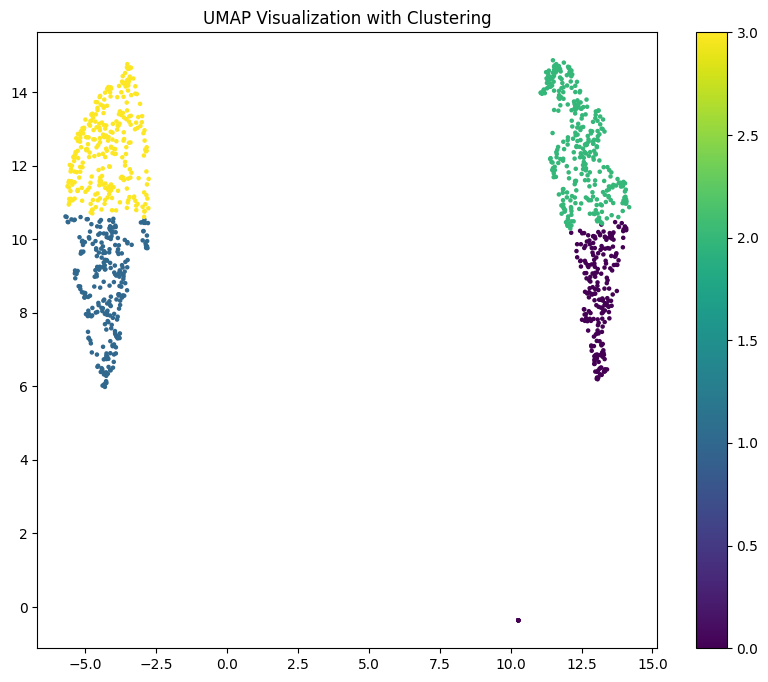

In [ ]:
import umap
from sklearn.cluster import KMeans

# Reshape the images for UMAP
train_images_flattened = train_images.reshape(train_images.shape[0], -1)

# params
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=42
)
embedding = reducer.fit_transform(train_images_flattened)

# clusters
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(embedding)

# plot
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=clusters, cmap='viridis', s=5)
plt.colorbar()
plt.title('UMAP Visualization with Clustering')
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step


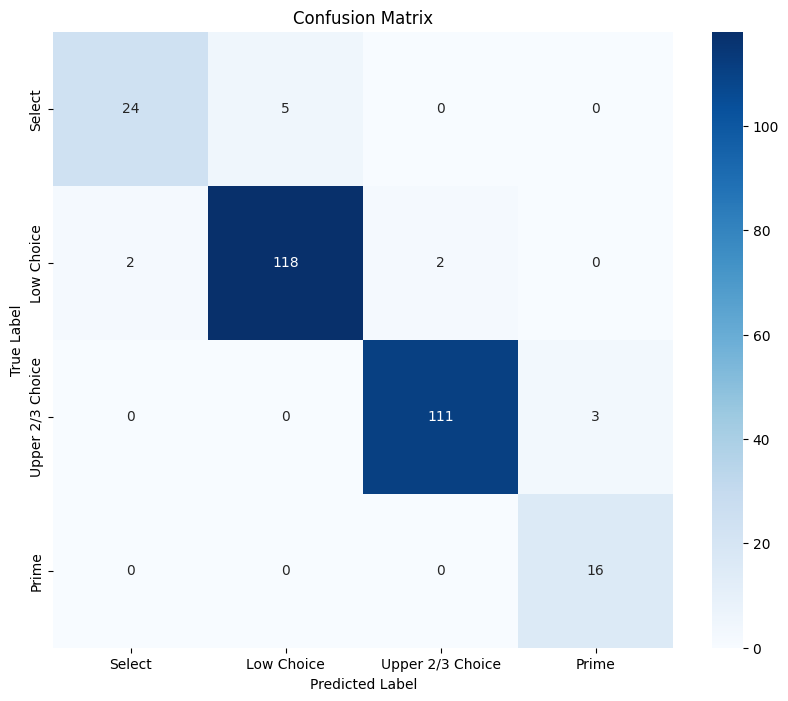

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#what did we predict
predictions = model.predict(validation_generator)
predicted_labels = np.argmax(predictions, axis=1)

# conf object
conf_matrix = confusion_matrix(validation_data['Label'], predicted_labels)

# plot!!
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=grade_mapping.keys(), yticklabels=grade_mapping.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Lame CNN

In [ ]:
model_path = 'C:/Users/coenp/Downloads/best_model (1).keras'  # Replace with the path to your friend's saved model
model = load_model(model_path)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
loss, accuracy = model.evaluate(validation_generator, verbose=1)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 4), output.shape=(None, 5)